In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict, Counter
import json
from transformers import pipeline
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DebertaForSequenceClassification
from datasets import load_dataset
from transformers import DebertaV2ForSequenceClassification, DebertaV2TokenizerFast, Trainer, TrainingArguments, DebertaTokenizerFast
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from transformers import TrainerCallback
from transformers import TrainerCallback, EvalPrediction

C:\Users\hetan\.conda\envs\pygpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("ag_news")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [4]:
tokenizer = DebertaTokenizerFast.from_pretrained('sileod/deberta-v3-small-tasksource-nli')

C:\Users\hetan\.conda\envs\pygpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DebertaV2Tokenizer'. 
The class this function is called from is 'DebertaTokenizerFast'.


In [5]:
train_text = dataset['train']['text']

# Calculate the maximum length
max_token_length = max(len(tokenizer.encode(text)) for text in train_text)
print(f"The maximum length in tokens is: {max_token_length}")


The maximum length in tokens is: 364


In [6]:
test_text = dataset['test']['text']

# Calculate the maximum length
max_token_length = max(len(tokenizer.encode(text)) for text in test_text)
print(f"The maximum length in tokens is: {max_token_length}")


The maximum length in tokens is: 260


In [8]:
# from transformers import DebertaV2ForSequenceClassification, DebertaTokenizerFast, Trainer, TrainingArguments

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=365)

# Apply tokenization to your dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Load the pre-trained Deberta model ignoring the size mismatches in the classifier layer
model = DebertaV2ForSequenceClassification.from_pretrained(
    'sileod/deberta-v3-small-tasksource-nli',
    num_labels=4,
    ignore_mismatched_sizes=True  # This will ignore the classifier weights and biases
)


Map: 100%|████████████████████████████████████████████████████████████| 120000/120000 [00:14<00:00, 8068.13 examples/s]
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at sileod/deberta-v3-small-tasksource-nli and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
model

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=T

In [10]:
# Compute metrics function for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "confusion_matrix": confusion_matrix(labels, predictions).tolist()
    }


# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    #lr_scheduler_type = 'cosine',
    per_device_train_batch_size=3,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

In [11]:
# Train and evaluate the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Confusion Matrix
1,0.348900,0.278706,0.943289,"[[1798, 15, 49, 38], [10, 1877, 8, 5], [42, 7, 1719, 132], [34, 6, 85, 1775]]"


Trainer is attempting to log a value of "[[1798, 15, 49, 38], [10, 1877, 8, 5], [42, 7, 1719, 132], [34, 6, 85, 1775]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=40000, training_loss=0.3489337646484375, metrics={'train_runtime': 9734.679, 'train_samples_per_second': 12.327, 'train_steps_per_second': 4.109, 'total_flos': 1.13329798416e+16, 'train_loss': 0.3489337646484375, 'epoch': 1.0})

In [12]:
results = trainer.evaluate()

Trainer is attempting to log a value of "[[1798, 15, 49, 38], [10, 1877, 8, 5], [42, 7, 1719, 132], [34, 6, 85, 1775]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [13]:
results

{'eval_loss': 0.2787061333656311,
 'eval_accuracy': 0.9432894736842106,
 'eval_confusion_matrix': [[1798, 15, 49, 38],
  [10, 1877, 8, 5],
  [42, 7, 1719, 132],
  [34, 6, 85, 1775]],
 'eval_runtime': 131.7618,
 'eval_samples_per_second': 57.68,
 'eval_steps_per_second': 14.42,
 'epoch': 1.0}

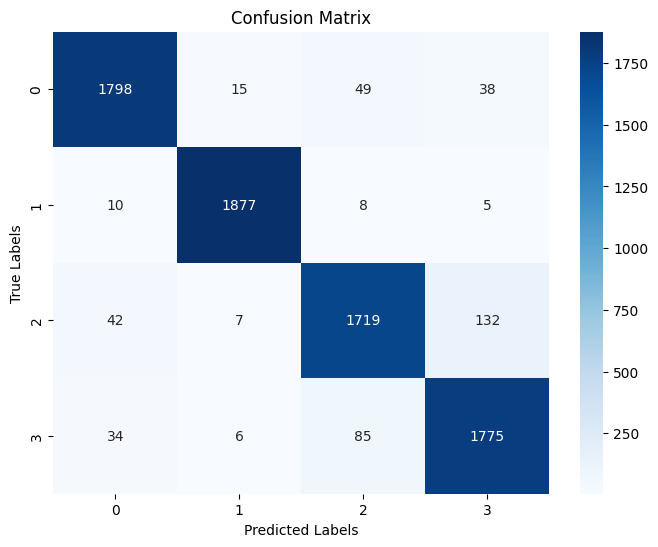

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = np.array(results['eval_confusion_matrix'])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
model_path = 'mda760_model'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('mda760_model\\tokenizer_config.json',
 'mda760_model\\special_tokens_map.json',
 'mda760_model\\unigram.json',
 'mda760_model\\added_tokens.json',
 'mda760_model\\tokenizer.json')

# Using the fine-tuned model

In [1]:
from transformers import DebertaV2ForSequenceClassification, DebertaTokenizerFast
import torch
model_path = 'mda760_model'  # Adjust this to the path where your model is saved
model = DebertaV2ForSequenceClassification.from_pretrained(model_path)
tokenizer = DebertaTokenizerFast.from_pretrained(model_path)
model.eval()  # Set the model to evaluation mode

C:\Users\hetan\.conda\envs\pygpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=T

## Classes:
0 : World
1 : Sports
2 : Business
3 : Sci/Tech

In [2]:
# Example statements
statements = [
    # World
    "Global leaders meet to discuss climate change solutions.",
    "Recent elections in Brazil have led to a surprising shift in leadership.",
    "The United Nations calls for immediate action on humanitarian crisis in Yemen.",
    "Diplomatic tensions escalate as trade talks between the U.S. and China stall.",
    "European countries consider more stringent border controls in response to rising migration.",

    # Sports
    "The Tokyo Olympics showcased outstanding performances in track and field.",
    "Manchester United wins the Premier League after a dramatic final match.",
    "Serena Williams announces retirement from professional tennis.",
    "NBA finals draw record viewership as the Lakers clinch the championship.",
    "FIFA World Cup to be held in Qatar faces criticism over labor conditions.",

    # Business
    "Tech stocks rally as new AI applications show promise for future growth.",
    "Amazon acquires a self-driving car startup in a multi-billion dollar deal.",
    "Global oil prices dip below $40 a barrel amid increased production.",
    "Apple launches a new innovative smartphone with advanced privacy features.",
    "Real estate prices soar in urban areas as remote work increases demand for larger spaces.",

    # Sci/Tech
    "NASA plans new mission to Mars to search for signs of past life.",
    "Breakthrough in quantum computing could revolutionize data security.",
    "Researchers discover a new sustainable energy source that could replace fossil fuels.",
    "The latest update to Python enhances speed and efficiency for developers.",
    "Artificial intelligence now able to diagnose diseases with accuracy surpassing human doctors."
]


# Tokenize all statements at once
inputs = tokenizer(statements, return_tensors="pt", padding=True, truncation=True, max_length=365)

# Move model to the appropriate device
if torch.cuda.is_available():
    model.to('cuda')
    inputs = {k: v.to('cuda') for k, v in inputs.items()}

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']  # Adjust based on your classes
probabilities = probabilities.cpu().numpy()

# Print probabilities with corresponding class names
for idx, statement_probs in enumerate(probabilities):
    best_prob_index = statement_probs.argmax()  # Get the index of the highest probability
    best_class = class_names[best_prob_index]
    best_probability = statement_probs[best_prob_index]
    print(f"Statement: {statements[idx]}")
    print(f"  Most likely class: {best_class} with probability {best_probability:.4f}")
    print()

Statement: Global leaders meet to discuss climate change solutions.
  Most likely class: World with probability 0.9369

Statement: Recent elections in Brazil have led to a surprising shift in leadership.
  Most likely class: World with probability 0.9948

Statement: The United Nations calls for immediate action on humanitarian crisis in Yemen.
  Most likely class: World with probability 0.9999

Statement: Diplomatic tensions escalate as trade talks between the U.S. and China stall.
  Most likely class: World with probability 0.9885

Statement: European countries consider more stringent border controls in response to rising migration.
  Most likely class: World with probability 0.9977

Statement: The Tokyo Olympics showcased outstanding performances in track and field.
  Most likely class: World with probability 0.9932

Statement: Manchester United wins the Premier League after a dramatic final match.
  Most likely class: World with probability 0.9973

Statement: Serena Williams announc

## Original model

In [16]:
from transformers import pipeline

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="sileod/deberta-v3-base-tasksource-nli")

In [20]:
statements = [
    # World
    "Global leaders meet to discuss climate change solutions.",
    "Recent elections in Brazil have led to a surprising shift in leadership.",
    "The United Nations calls for immediate action on humanitarian crisis in Yemen.",
    "Diplomatic tensions escalate as trade talks between the U.S. and China stall.",
    "European countries consider more stringent border controls in response to rising migration.",

    # Sports
    "The Tokyo Olympics showcased outstanding performances in track and field.",
    "Manchester United wins the Premier League after a dramatic final match.",
    "Serena Williams announces retirement from professional tennis.",
    "NBA finals draw record viewership as the Lakers clinch the championship.",
    "FIFA World Cup to be held in Qatar faces criticism over labor conditions.",

    # Business
    "Tech stocks rally as new AI applications show promise for future growth.",
    "Amazon acquires a self-driving car startup in a multi-billion dollar deal.",
    "Global oil prices dip below $40 a barrel amid increased production.",
    "Apple launches a new innovative smartphone with advanced privacy features.",
    "Real estate prices soar in urban areas as remote work increases demand for larger spaces.",

    # Sci/Tech
    "NASA plans new mission to Mars to search for signs of past life.",
    "Breakthrough in quantum computing could revolutionize data security.",
    "Researchers discover a new sustainable energy source that could replace fossil fuels.",
    "The latest update to Python enhances speed and efficiency for developers.",
    "Artificial intelligence now able to diagnose diseases with accuracy surpassing human doctors."
]

# Candidate labels
candidate_labels = ['World', 'Sports', 'Business', 'Sci/Tech']

In [21]:
# Classify each statement
results = []
for text in statements:
    result = classifier(text, candidate_labels)
    results.append(result)

In [22]:
# Print classification results for each statement
for statement, result in zip(statements, results):
    print(f"Statement: {statement}")
    for label, score in zip(result['labels'], result['scores']):
        print(f"  Label: {label}, Score: {score:.4f}")
    print()

Statement: Global leaders meet to discuss climate change solutions.
  Label: World, Score: 0.4189
  Label: Sci/Tech, Score: 0.3878
  Label: Business, Score: 0.1515
  Label: Sports, Score: 0.0417

Statement: Recent elections in Brazil have led to a surprising shift in leadership.
  Label: World, Score: 0.4536
  Label: Sports, Score: 0.1956
  Label: Business, Score: 0.1787
  Label: Sci/Tech, Score: 0.1721

Statement: The United Nations calls for immediate action on humanitarian crisis in Yemen.
  Label: World, Score: 0.5142
  Label: Sci/Tech, Score: 0.2783
  Label: Business, Score: 0.1166
  Label: Sports, Score: 0.0908

Statement: Diplomatic tensions escalate as trade talks between the U.S. and China stall.
  Label: Business, Score: 0.4580
  Label: World, Score: 0.3601
  Label: Sci/Tech, Score: 0.1224
  Label: Sports, Score: 0.0594

Statement: European countries consider more stringent border controls in response to rising migration.
  Label: World, Score: 0.4028
  Label: Sci/Tech, Score